In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50
import xarray as xr
import numpy as np
from tensorflow import keras

In [2]:
tf.__version__

'2.1.0'

In [3]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

In [4]:
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
    'constants': ['orography']
}

In [5]:
ds = [xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]
ds_whole = xr.merge(ds, compat = 'override')

# load all training data
ds_train = ds_whole.sel(time=slice('2015', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, bins_z = None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]

        output_data = self.data.isel(level = self.output_idxs)

        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std

        self.bins_z = np.linspace(output_data.min(), output_data.max(), 100) if bins_z is None else bins_z

        self.binned_data = xr.DataArray(
               np.digitize(output_data[:, :, :, 0], self.bins_z)-1,
               dims=['time', 'lat', 'lon'],
               coords={'time':self.data.time.values, 'lat': self.data.lat.values, 'lon': self.data.lon.values
               })

        del ds
        
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time   
        
        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()
        if load: print('Loading data into RAM'); self.binned_data.load() 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.binned_data.isel(time=idxs + self.lead_time).values
        return X, y   
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)    

In [7]:
import re

bs=32
lead_time=72
output_vars = ['z_500']

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('2015', '2015')), var_dict, lead_time, batch_size=bs, load=True, output_vars = output_vars)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False, bins_z = dg_train.bins_z, output_vars = output_vars)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, bins_z = dg_train.bins_z,
                         shuffle=False, output_vars=output_vars)


Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM


In [8]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 64, 3))

In [9]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
class PeriodicPadding2D(keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

In [11]:
x = resnet_model.output
x = GlobalMaxPooling2D()(x)
x = Reshape((32, 64, 1))(x)
x = PeriodicConv2D(100, 5)(x)
x = LeakyReLU()(x)
#x = BatchNormalization()(x)
x = PeriodicConv2D(100, 5)(x)
x = LeakyReLU()(x)
#x = BatchNormalization()(x)
out = Reshape((32*64, 100), input_shape = (32, 64, 100))(x)
out = Activation('softmax')(out)
predictions = Reshape((32, 64, 100), input_shape = (32*64, 100))(out)

In [14]:
model =  tf.keras.models.Model(resnet_model.input, predictions)
model.compile(tf.keras.optimizers.Adam(1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=10,
                        verbose=1, 
                        mode='auto'
                    )

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience=2,
            factor=0.2,
            verbose=1)


model.fit(dg_train, validation_data = dg_valid, epochs  = 100, callbacks = [early_stopping_callback, reduce_lr_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 272 steps, validate for 273 steps
Epoch 1/100
272/272 [==============================] - 2731s 10s/step - loss: 2.0249 - sparse_categorical_accuracy: 0.2898 - val_loss: 3.7397 - val_sparse_categorical_accuracy: 0.1254
Epoch 2/100
272/272 [==============================] - 2790s 10s/step - loss: 1.9903 - sparse_categorical_accuracy: 0.2982 - val_loss: 3.8189 - val_sparse_categorical_accuracy: 0.1269
Epoch 3/100
271/272 [============================>.] - ETA: 7s - loss: 1.9594 - sparse_categorical_accuracy: 0.3057 
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
272/272 [==============================] - 2665s 10s/step - loss: 1.9594 - sparse_categorical_accuracy: 0.3057 - val_loss: 3.8873 - val_sparse_categorical_accuracy: 0.1262
Epoch 4/100
272/272 [==============================] - 2334s 9s/step - loss: 1.9120 - sparse_categorical_accuracy: 0.3214 - val_loss: 3.8788 - val_sparse_categorical_ac

In [15]:
fc = model.predict(dg_test)

In [16]:
fc_arg = fc.argmax(axis = -1)

for i in range(100):
    fc_arg[fc_arg == i] = dg_test.bins_z[i]

In [17]:
fc_conv_ds = xr.Dataset({
    'z': xr.DataArray(
        fc_arg,
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})

In [18]:
from src.score import *

compute_weighted_rmse(fc_arg, ds_test.z.sel(level=500)[72:]).compute()

<xarray.DataArray ()>
array(959.12770532)
Coordinates:
    level    int32 500

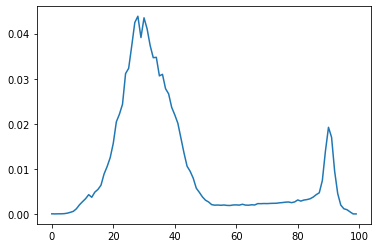

In [26]:
import pylab as plt
plt.plot(fc[0][0][0])